# LATEST MASK

In [30]:
"""
Author: Dingchao Zhang
Masking Methods: Jing 
Aaptive Height Threshold :Sripriya
Created: Aug 13, 2016
Script to estimate roof area using 2d data, adaptive Height masking, median filetering, etc.
"""


import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import argparse
import gdal                     #part of gdal 1.11
from gdalconst import *         #part of gdal 1.11
import glob
import matplotlib.pyplot as plt
import csv
import time
import pandas as pd
from collections import Counter
%matplotlib inline

# MODE EDGE is on edgenode which has opencv2, MODE LOCAL is on local mac which has opencv3
if cv2.__version__[0] == '2':
	MODE = 'EDGE'
	
elif cv2.__version__[0] == '3':
	MODE = 'LOCAL'

# SET UP OS
if MODE == 'EDGE':
	os.chdir(r'/san-data/usecase/skyscout/ARI-HackWeek')
elif MODE == 'LOCAL':
	os.chdir(r'/Users/ejlq/Documents/ARI-HackWeek')

    
def read_projdsm(dsm):
    """
    Read dsm/project_dsm.tif and return project_dsm read as an array
    containing height info
    
    """
    
    geofile = gdal.Open(dsm,0)
    project_dsm_1 = geofile.GetRasterBand(1)
    project_dsm = project_dsm_1.ReadAsArray()
    
    return project_dsm,geofile

def load_orthomosaic(orthom):
    """
    Load orthomosaic file and return rgbArray
    """
    pixelimageDS = gdal.Open(orthom)
    pr_data = pixelimageDS.GetRasterBand(1)
    pg_data = pixelimageDS.GetRasterBand(2)
    pb_data = pixelimageDS.GetRasterBand(3)
    #pa_data = pixelimageDS.GetRasterBand(4)

    r_data = pr_data.ReadAsArray()
    g_data = pg_data.ReadAsArray()
    b_data = pb_data.ReadAsArray()
    #a_data = pa_data.ReadAsArray()

    rgbArray = np.dstack((r_data, g_data, b_data))
    return rgbArray

def hsv_mask(rgbArray):
    """
    Load rgbArray read from orthomosaic file and return a mask for filter green color points
    """
    hsv_rgb = cv2.cvtColor(rgbArray, cv2.COLOR_BGR2HSV)

    ## define range of green color in HSV    
    lower_rgb = np.array([65,20,20])
    upper_rgb = np.array([85,255,255])

    # Threshold the HSV image to create a mask for filter green color points
    mask_rgb= 255 - cv2.inRange(hsv_rgb, lower_rgb, upper_rgb)
    mask_rgb = cv2.medianBlur(mask_rgb,15)
    
    return mask_rgb

def adaptive_thresh(cloud_file, offset = 1.5):
    df = pd.read_csv(cloud_file, header=None)
    cloud_data = df.as_matrix()
    zValues = cloud_data[:,2]
    zNum = [np.int(i) for i in zValues]
    freq = Counter(zNum)
    maxZVal = [i[0] for i in freq.most_common() if i[0] > 3][0]
    #maxZVal = maxZVal - offset
    maxZVal = 2
    if maxZVal > 7:
        maxZVal = 6.5
    elif maxZVal < 4:
        maxZVal = 3.5
        
    print "Height Threshold : %f " % maxZVal
    
    return maxZVal 


def height_mask(project_dsm,thresh):
    """
    Load project_dsm and create height mask
    """
    mask_height = project_dsm > thresh
    mask_height = mask_height.astype(int)
    mask_height = cv2.convertScaleAbs(mask_height)
    mask_height = cv2.medianBlur(mask_height,15)
    return mask_height
    

def mask_add(mask_height,mask_rgb):
    """
    Combine color and height mask, denoise and return new masked project
    """
    
    ## Combine the tree mask with height mask
    mask_combined = cv2.bitwise_and(mask_height,mask_rgb)
    # Remove noises using open operation (Erosion followed by Dilation) to remove noises outside of the objects.
    kernel = np.ones((20,20),np.uint8)
    mask_denoise = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel)
    return mask_denoise,mask_combined

def filtering(thresh1,filter_window = 151):
    """
    Apply Median Filter

    """    
    median = cv2.medianBlur(thresh1,filter_window)
    
    return median

def create_contours(median):

    """
    Find contours

    """
    mask = median.copy()
    if MODE == 'EDGE':
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    elif MODE == 'LOCAL':
        _, contours, _ = cv2.findContours(mask, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#     contours, _ = cv2.findContours(median, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    return contours
#     _, contours, _ = cv2.findContours(median, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#     return contours

def vis_imgprocess(rgbArray,mask_rgb,mask_height,mask_combined,mask_denoise,contours,index):

    """

    Gerenrates visualizations of the intermediate and final img processes

    """    

    #img_dummy = mask_denoise.copy()

    plt.figure(figsize=(12,12));
    plt.subplot(231), plt.imshow(rgbArray), plt.title('orthomosaic image') 
    plt.subplot(232), plt.imshow(mask_rgb,cmap='gray'), plt.title('tree mask')
    plt.subplot(233), plt.imshow(mask_height,cmap='gray'), plt.title('height mask')
    plt.subplot(234), plt.imshow(mask_combined,cmap='gray'), plt.title('combined mask')
    plt.subplot(235), plt.imshow(mask_denoise,cmap='gray'), plt.title('combined mask after denoising')
    largest_contour = contours[index]
    ImgWithContour = cv2.drawContours(rgbArray.copy(), [largest_contour], 0, (255,0,255), 100)
    plt.subplot(236), plt.imshow(ImgWithContour), plt.title('Image with laregest contour')
    
    plt.show()
    
    
def georef(geofile):
    """
    Get pixel width and height in meters

    """    
        
    geoTransf = geofile.GetGeoTransform()
    xOrigin = geoTransf[0]
    yOrigin = geoTransf[3]
    pixelWidth = abs(geoTransf[1])
    pixelHeight = abs(geoTransf[5])
    
    return pixelWidth,pixelHeight

def max_contour(contours):
    """
    find the largest contour, return its number of pixels and index
    
    """
    count,index = max([(cv2.contourArea(v),i) for i,v in enumerate(contours)])
    
    print 'The number of pixels in the largest contour is:', count
    print 'The index of contour which is the largst is:' , index
    
    return count,index
    
def compute_area_2d(count,pixW = 0.00406,pixH = 0.00406,s2rRatio = 1.302):

    """

    Compute area using 2d info

    """ 
    ##DICTIONARY COMPREHENSION EFFICIENT
    
    #c,index = max([(cv2.contourArea(v),i) for i,v in enumerate(contours)])
    
    
    sqM2sqF = 10.7639
    #area = cv2.contourArea(cv2.convexHull(contours[index]))*pixW*pixH*s2rRatio*sqM2sqF
    #area = cv2.contourArea(contours[index])*pixW*pixH*s2rRatio*sqM2sqF
    area = count*pixW*pixH*s2rRatio*sqM2sqF
    return area

def create_groundTruth(targetCSV):
    """
    Read ARI-target file, return a dictionary with key as house name, actual
    area as item
    
    """
    with open(targetCSV, mode='r') as infile:
        reader = csv.reader(infile)
#  with open('coors_new.csv', mode='w') as outfile:
#             writer = csv.writer(outfile)
        mydict = {rows[0]:rows[1] for rows in reader}
        
    return mydict
    
def evaluate(actual_dict,house,prediction):
    """
    Compute RMSE, perc_error
    """
    
    house = house +'.pdf'
    try:
        target = float(actual_dict[house])
    except:
        target = 999.12345
    RMSE = np.sqrt(np.mean((prediction-target)**2))
    perc_error = (prediction - target)/target
    print 'actual roof sqft is:', target
    print 'RMSE is:', RMSE
    print 'perc_error:', perc_error
    
    return target,RMSE,perc_error

#img_3d = project_dsm
def blob_selector(contours, selection_index, img_3d):
    cimg = np.zeros_like(img_3d)
    cv2.drawContours(cimg, contours, selection_index, color=255, thickness=-1)
    blob_of_interest = cimg * img_3d
    return blob_of_interest


def cutZeroPixels(Array3d):
    """
    This function reduces the array size to cut out as many zero pixels as
    possible while maintaining an mxn array shape. This is meant to reduce the
    computational time to run the median filter on the gradient array
    """
    
    cut_zero_rows = Array3d[~np.all(Array3d == 0, axis=1)]
    return cut_zero_rows[:, ~np.all(cut_zero_rows == 0, axis=0)]
#Array3D = project_dsm --- with largest contour mapped in

def computeAreaByMedianGradient(Array3D, area_one_pixel):
    #Array3D = metersToFeet(Array3D)
    g = np.gradient(Array3D)
    slope_multiplier = np.sqrt(g[0]**2 + g[1]**2 + 1) * (Array3D > 0)
    slope_multiplier_median = np.median(slope_multiplier[slope_multiplier > 0])
    pixel_area = slope_multiplier_median * (Array3D > 0) * area_one_pixel * 10.7639
    return np.nansum(pixel_area), slope_multiplier_median

def compute_area_3d(contours, index, project_dsm,pixW,pixH):
    blob_of_interest = blob_selector(contours, index, project_dsm)
    cut = cutZeroPixels(blob_of_interest)
    area_one_pixel = pixW * pixH
    est3d,major_pitch = computeAreaByMedianGradient(cut, area_one_pixel)
    print 'using 3d method, estimated roof area is:', est3d
    print 'using 3d method, estimated major pitch is:', major_pitch
    return est3d,major_pitch


    
def pipeline_height(dsm,orthom,cloud_file):
	"""
	 Pileline all processing functions together using height mask only
     filename: color_relief.tif
     dsm: project_dsm.tif
     now the order is apply height mask then rgb mask
     good to try a different order --TODO!!
     
	"""
	start_time = time.time()

	# Load project_dsm, orthmosaic and point cloud files
	project_dsm,geofile = read_projdsm(dsm)
	rgbArray = load_orthomosaic(orthom)
	maxZVal = adaptive_thresh(cloud_file)
    
	# Create masks and return masked project
	mask_rgb = hsv_mask(rgbArray)
	mask_height = height_mask(project_dsm,thresh = maxZVal)
	mask_denoise,mask_combined = mask_add(mask_height,mask_rgb)
	median = filtering(mask_denoise)
	# Find contours and return the largest one
	contours = create_contours(median) 
	c,index = max_contour(contours) 

	# Predict roof area
	pixW,pixH = georef(geofile) # get pixel width and height in meters
	areaEst = compute_area_2d(c,pixW = pixW,pixH = pixH)
	areaEst_3d,major_pitch = compute_area_3d(contours, index, project_dsm,pixW,pixH)
	#vis_imgprocess(rgbArray,mask_rgb,mask_height,mask_combined,mask_denoise,contours,index) # visualize

    ###
    ###The following lines of code adjust height threshold based on the estimated area of first round
    ###and re-estimate roof square feet
    
# 	if areaEst < 900:
# 		mask_height = height_mask(project_dsm,thresh = 3)
# 		mask_denoise,mask_combined = mask_add(mask_height,mask_rgb)
# 		median = filtering(mask_denoise)
# 		# Find contours and return the largest one
# 		contours = create_contours(median) 
# 		c,index = max_contour(contours) 

# 	# Predict roof area
# 		pixW,pixH = georef(geofile) # get pixel width and height in meters
# 		areaEst = compute_area_2d(contours,index,pixW = pixW,pixH = pixH)
# 		vis_imgprocess(rgbArray,mask_rgb,mask_height,mask_combined,mask_denoise,contours,index) # visualize

# 	elif areaEst > 10000:
# 		mask_height = height_mask(project_dsm,thresh = 8)
# 		mask_denoise,mask_combined = mask_add(mask_height,mask_rgb)
# 		median = filtering(mask_denoise)
# 		# Find contours and return the largest one
# 		contours = create_contours(median) 
# 		c,index = max_contour(contours) 

#	# Predict roof area
# 		pixW,pixH = georef(geofile) # get pixel width and height in meters
# 		areaEst = compute_area_2d(contours,index,pixW = pixW,pixH = pixH)
# 		vis_imgprocess(rgbArray,mask_rgb,mask_height,mask_combined,mask_denoise,contours,index) # visualize

        
	exe_time = time.time() - start_time
	print "estimated area square feet is using height mask only is \n", areaEst
	print "seconds ",exe_time
	return areaEst,areaEst_3d,exe_time,maxZVal,major_pitch
	
    
    
    
    
def main():  
    start_time = time.time()
    
    	
    if MODE == 'LOCAL':
    	rootdir = '/Users/ejlq/Documents/ARI-HackWeek/all_training/training/'
    	target_dict = create_groundTruth('ARI-targets.csv')
    elif MODE == 'EDGE':
    	rootdir = '/san-data/usecase/skyscout/ARI-HackWeek/training/'
    	target_dict = create_groundTruth('/home/ejlq/ARI-targets.csv')
    results = []
    
    files = [x for x in os.listdir(rootdir) if not x.startswith('.')]
    
    for f in files:
            
        result = []
        dsm = rootdir + f + '/dsm/project_dsm.tif'
        orthom = rootdir + f + '/orthomosaic_rgb/project_transparent_mosaic_rgb.tif'
        cloud_file = rootdir + f + '/point_cloud/project_densified_point_cloud.xyz'
        print '----computing the following house now:' , f

            
        #est, exe_time= pipeline_height(dsm,orthom,cloud_file)
        try:
        	est,est_3d,exe_time,maxZVal,major_pitch= pipeline_height(dsm,orthom,cloud_file)
        except:
        	est,est_3d,exe_time,maxZVal,major_pitch = 2700,2700, 10000,6,1.41
        	print 'estimation error out'
        target,RMSE,perc_error = evaluate(target_dict,f,est)
        target,RMSE_3d,perc_error_3d = evaluate(target_dict,f,est_3d)
            
        result.append(f)
        result.extend([est,est_3d,target,exe_time,RMSE,RMSE_3d,perc_error_3d,perc_error,maxZVal,major_pitch])
        results.append(result)

    
    if MODE == 'LOCAL' :
       
    	with open("output2.csv", "wb") as f:
    		writer = csv.writer(f)
    		writer.writerow(['House','Predicted','Predicted_3d',\
                             'Target','Exe_time','RMSE','RMSE_3d',\
                             'Perc_error_3d','Perc_error','maxZVal','major_pitch'])
    		writer.writerows(results)
    elif MODE == 'EDGE' :
        os.chdir('/home/ejlq/hackweek/output/')
    	with open("output.csv", "wb") as f:
    		writer = csv.writer(f)
    		writer.writerow(['House','Predicted','Predicted_3d',\
                             'Target','Exe_time','RMSE','RMSE_3d',\
                             'Perc_error_3d','Perc_error','maxZVal','major_pitch'])
    		writer.writerows(results)
        
    print 'results saved to output.csv'
    print 'in total takes the followig minutes to run', (time.time() - start_time)/60
    return results
        
                

# if __name__ == '__main__':
#     main()

### Tried to calculate height cut threshold

In [18]:
import pandas as pd
cloud_file = '/Users/ejlq/Documents/ARI-Hackweek/training/989f9066-5eec-4d2e-b684-c631a9937243/point_cloud/project_densified_point_cloud.xyz'
df = pd.read_csv(cloud_file, header=None)
cloud_data = df.as_matrix()

In [67]:
from collections import Counter
zValues = cloud_data[:,2]
zNum = [np.int(i) for i in zValues]
freq = Counter(zNum)
maxZVal = [i[0] for i in freq.most_common() if i[0] > 3][0]
print "Height Threshold : %f " % maxZVal

Height Threshold : 6.000000 


In [ ]:
#zValues = project_dsm.flatten().tolist()
zValues = pd.DataFrame(project_dsm[:,:])
zNum = [np.int(i) for i in zValues]
freq = Counter(zNum)
maxZVal = [i[0] for i in freq.most_common() if i[0] > 3][0]
print "Height Threshold : %f " % maxZVal

In [ ]:
def adaptive_thresh(cloud_file):
    df = pd.read_csv(cloud_file, header=None)
    cloud_data = df.as_matrix()
    zValues = cloud_data[:,2]
    zNum = [np.int(i) for i in zValues]
    freq = Counter(zNum)
    maxZVal = [i[0] for i in freq.most_common() if i[0] > 3][0]
    print "Height Threshold : %f " % maxZVal
    
    return maxZVal
    

### Reserved for single file test only for parameter tuning

In [25]:
def singletest(f_name):
    
    rootdir = '/Users/ejlq/Documents/ARI-Hackweek/all_training/training/'
    f = f_name
    dsm = rootdir + f + '/dsm/project_dsm.tif'
    orthom = rootdir + f + '/orthomosaic_rgb/project_transparent_mosaic_rgb.tif'
    cloud_file = rootdir + f + '/point_cloud/project_densified_point_cloud.xyz'

    project_dsm,geofile = read_projdsm(dsm)
    rgbArray = load_orthomosaic(orthom)
    maxZVal = adaptive_thresh(cloud_file)
    # Create masks and return masked project
    mask_rgb = hsv_mask(rgbArray)
    mask_height = height_mask(project_dsm,thresh = maxZVal)
    mask_denoise,mask_combined = mask_add(mask_height,mask_rgb)
    median = filtering(mask_denoise)
    # Find contours and return the largest one
    contours = create_contours(median) 
    c,index = max_contour(contours) 
    vis_imgprocess(rgbArray,mask_rgb,mask_height,mask_combined,mask_denoise,contours,index)
    # Predict roof area
    pixW,pixH = georef(geofile) # get pixel width and height in meters
    areaEst = compute_area_2d(c,pixW = pixW,pixH = pixH)

    print areaEst

## Under Predicted

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 10373031.5
The index of contour which is the largst is: 17


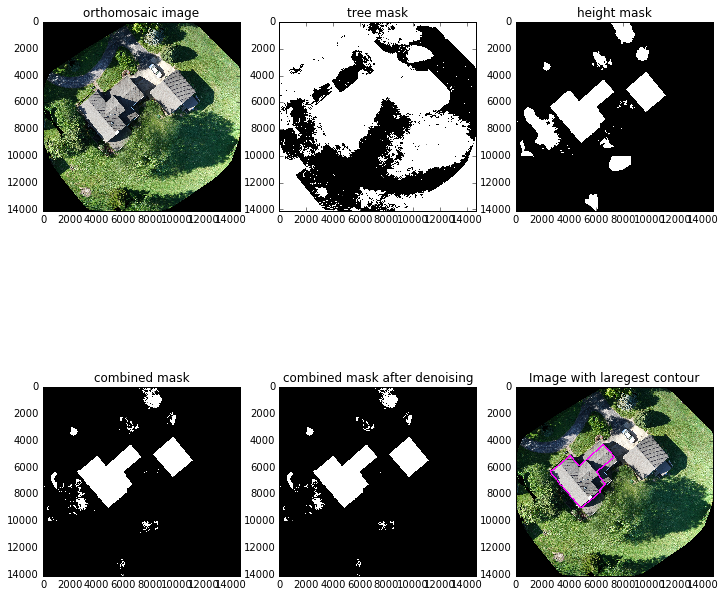

2479.62746835


In [26]:
rootdir = '/Users/ejlq/Documents/ARI-Hackweek/all_training/training/'
f = '8f97f6d9-6239-4884-a447-f63d00a852ce'
dsm = rootdir + f + '/dsm/project_dsm.tif'
orthom = rootdir + f + '/orthomosaic_rgb/project_transparent_mosaic_rgb.tif'
cloud_file = rootdir + f + '/point_cloud/project_densified_point_cloud.xyz'

project_dsm,geofile = read_projdsm(dsm)
rgbArray = load_orthomosaic(orthom)
maxZVal = adaptive_thresh(cloud_file)
# Create masks and return masked project
mask_rgb = hsv_mask(rgbArray)
mask_height = height_mask(project_dsm,thresh = maxZVal)
mask_denoise,mask_combined = mask_add(mask_height,mask_rgb)
median = filtering(mask_denoise)
# Find contours and return the largest one
contours = create_contours(median) 
c,index = max_contour(contours) 
vis_imgprocess(rgbArray,mask_rgb,mask_height,mask_combined,mask_denoise,contours,index)
# Predict roof area
pixW,pixH = georef(geofile) # get pixel width and height in meters
areaEst = compute_area_2d(c,pixW = pixW,pixH = pixH)

print areaEst

### Two seperate houses! ignore this file 8f97f6d9-6239-4884-a447-f63d00a852ce

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 11879847.5
The index of contour which is the largst is: 21


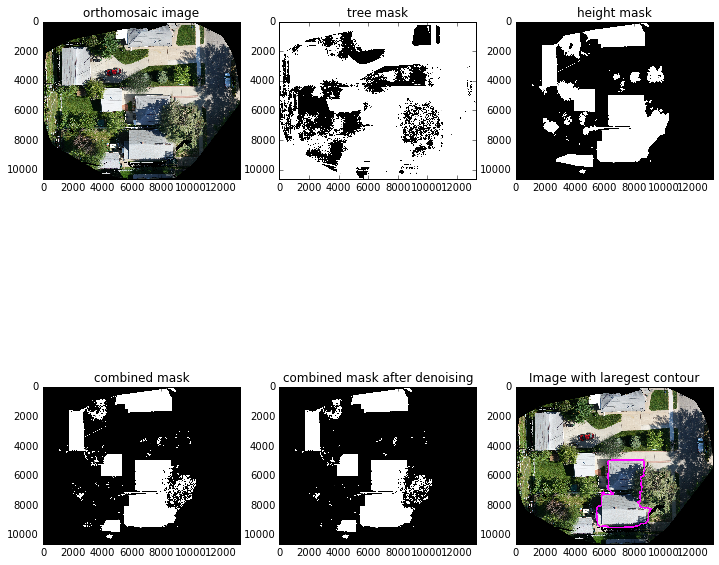

3326.64570922


In [8]:
singletest('773d2d69-e34c-4857-bfb2-225cc75b7b57')

### 2 meter thresh

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 11879847.5
The index of contour which is the largst is: 21


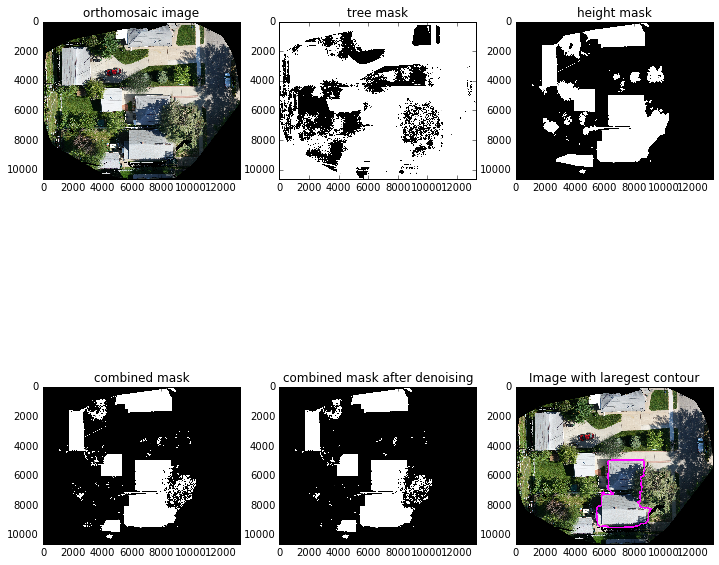

3326.64570922


In [27]:
singletest('773d2d69-e34c-4857-bfb2-225cc75b7b57')

## Two houses! shall we use coordinate info to get the closest house only?

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 11059239.5
The index of contour which is the largst is: 1


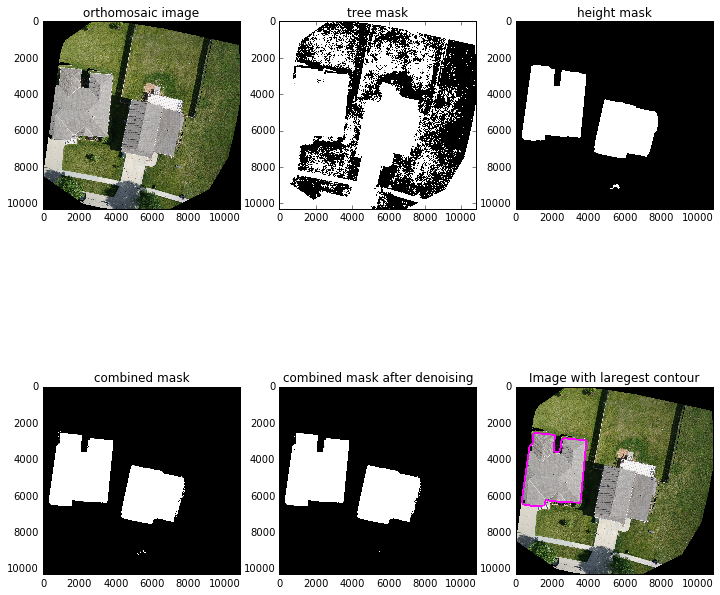

2812.71092533


In [10]:
singletest('312d39cd-cb1d-4919-b04e-155b3a994e56')

### The house below is under predicted but contour fits well!

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 6839156.5
The index of contour which is the largst is: 1


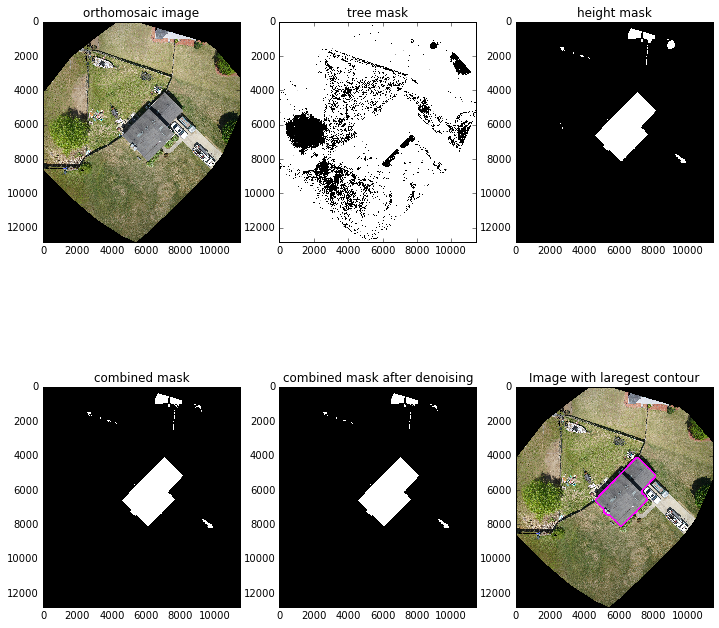

1915.12985545


In [11]:
singletest('c8cbc55a-36d3-49c3-9685-d5ba498dd46f')

### Need to remove trees first, then find height threshold!!

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 1989254.5
The index of contour which is the largst is: 5


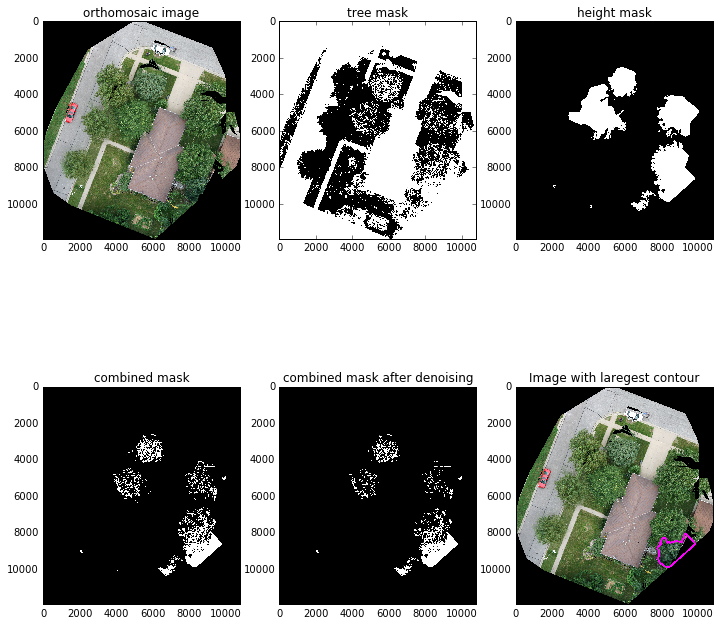

544.64751502


In [12]:
singletest('3553c4de-32a7-4d8d-86a9-41ba64fd8110')

### 2 meter thresh

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 1989254.5
The index of contour which is the largst is: 5


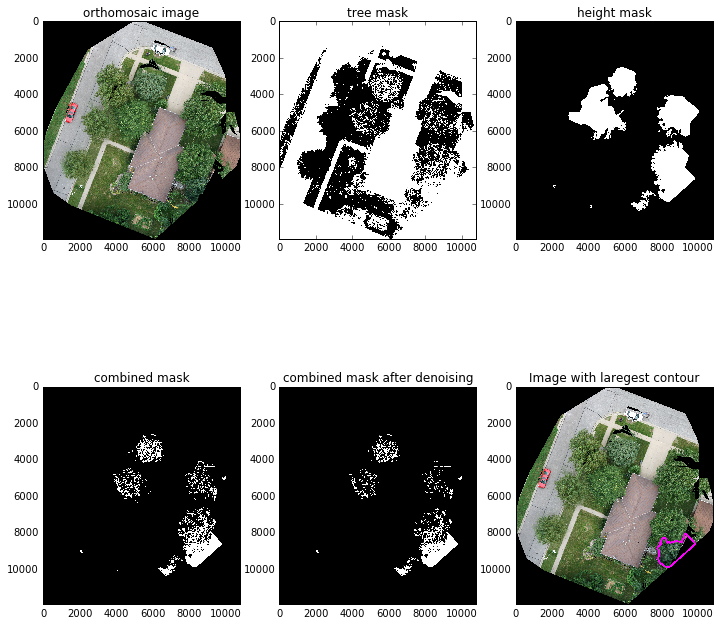

544.64751502


In [29]:
singletest('3553c4de-32a7-4d8d-86a9-41ba64fd8110')

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 4481757.0
The index of contour which is the largst is: 15


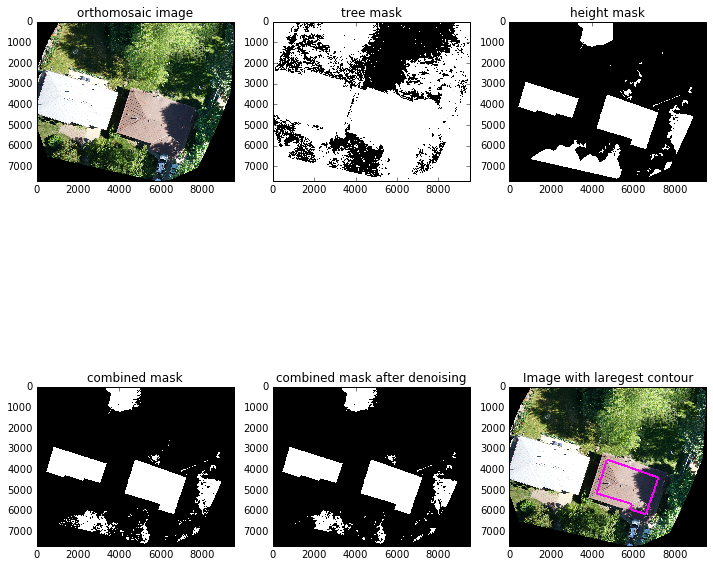

1323.28782012


In [16]:
singletest('8b459f92-626c-46a9-8133-89ad9e614cbe')

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 1269290.0
The index of contour which is the largst is: 0


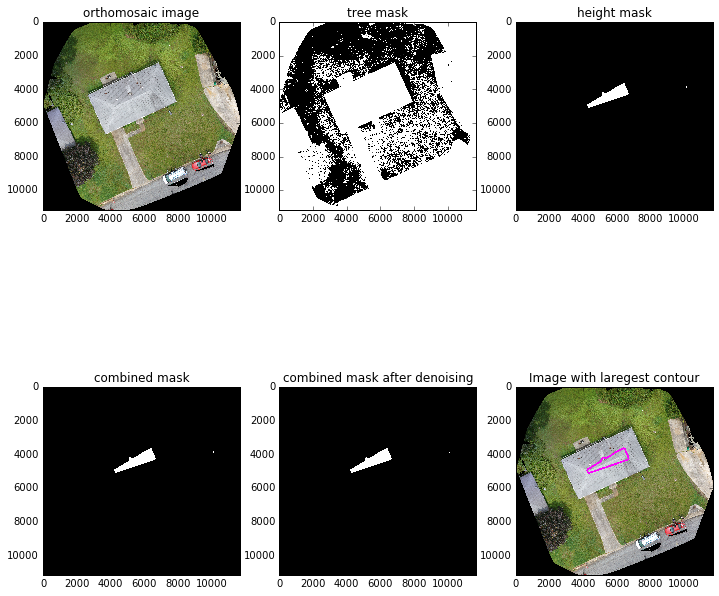

251.487953606


In [15]:
singletest('866a3a7a-dac3-4e81-b1af-8cc579fa3754')

### 2 meter thresh

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 1487944.0
The index of contour which is the largst is: 9


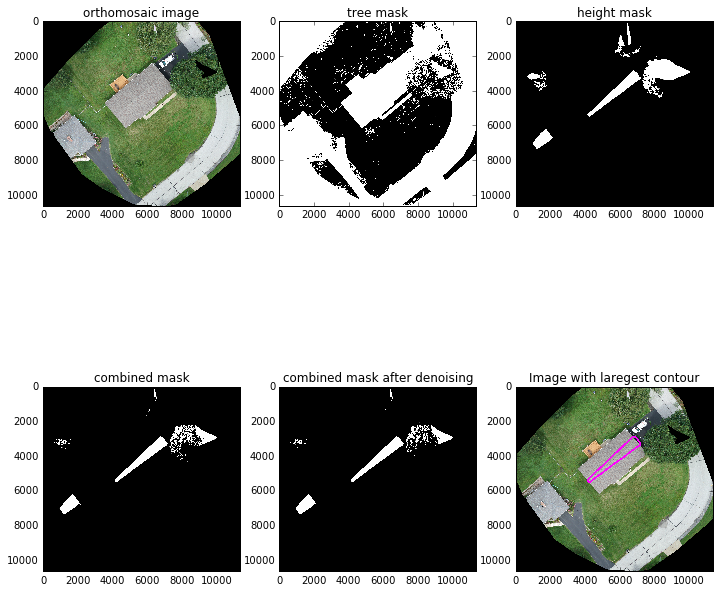

500.679010381


In [17]:
singletest('c6c0d1c9-7e16-40c4-9940-5dcbab822f6e')

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 16384036.0
The index of contour which is the largst is: 2


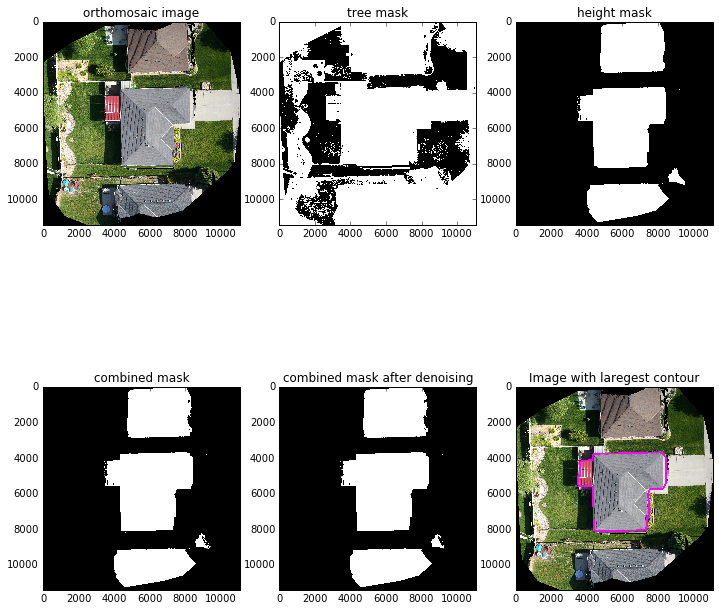

2812.79201729


In [18]:
singletest('421be199-02e8-4ad4-8357-f6f5b6c52407')

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 3792659.5
The index of contour which is the largst is: 30


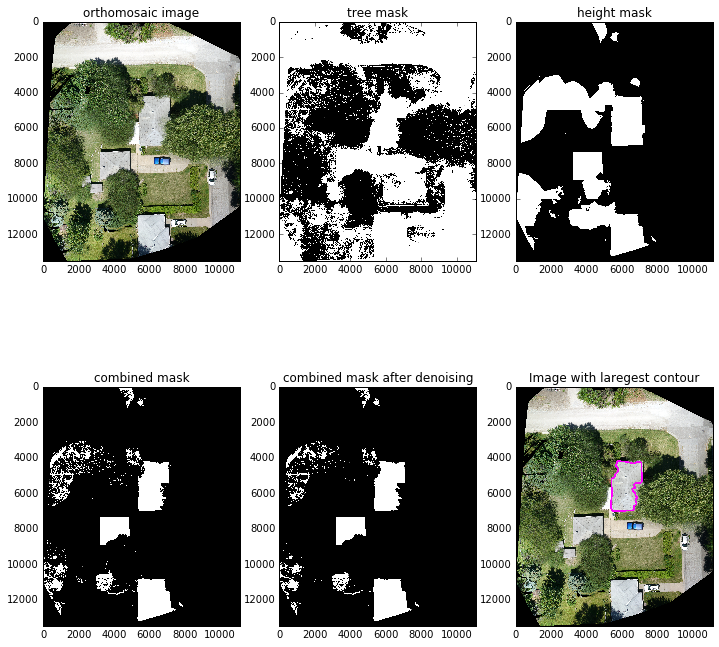

1355.52411736


In [19]:
singletest('40dd7f5a-b1ee-4578-9529-96c009d08b26')

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 12871168.0
The index of contour which is the largst is: 5


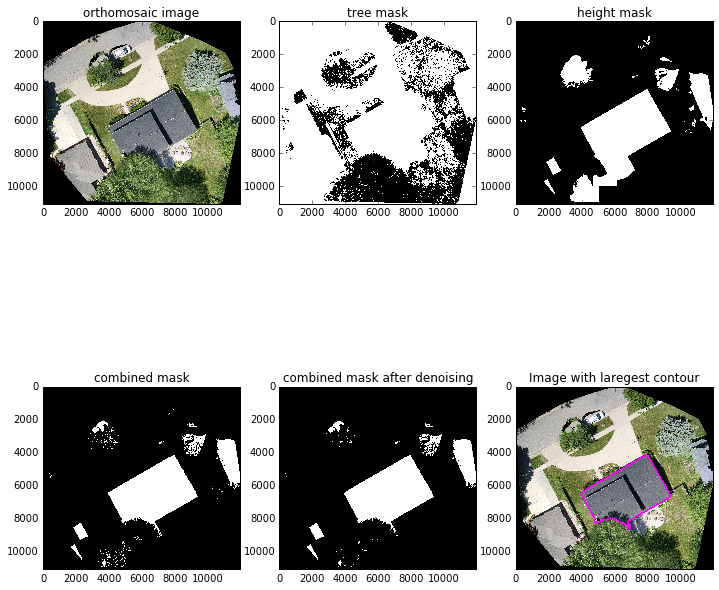

2915.08151631


In [20]:
singletest('4bf60e38-9949-422a-a10f-f1b46326a916')

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 15829548.0
The index of contour which is the largst is: 29


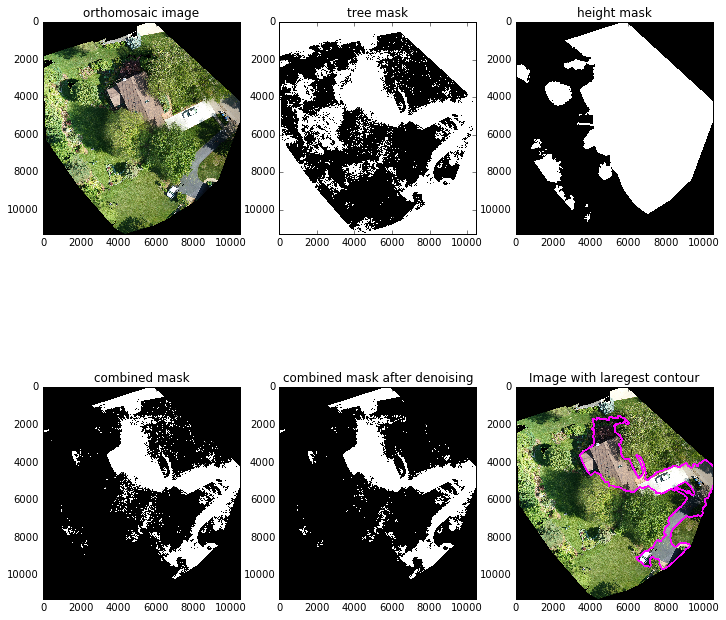

7031.79081113


In [21]:
singletest('8fdb609a-934c-46a6-90af-dd63d7d49962')

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 1487944.0
The index of contour which is the largst is: 9


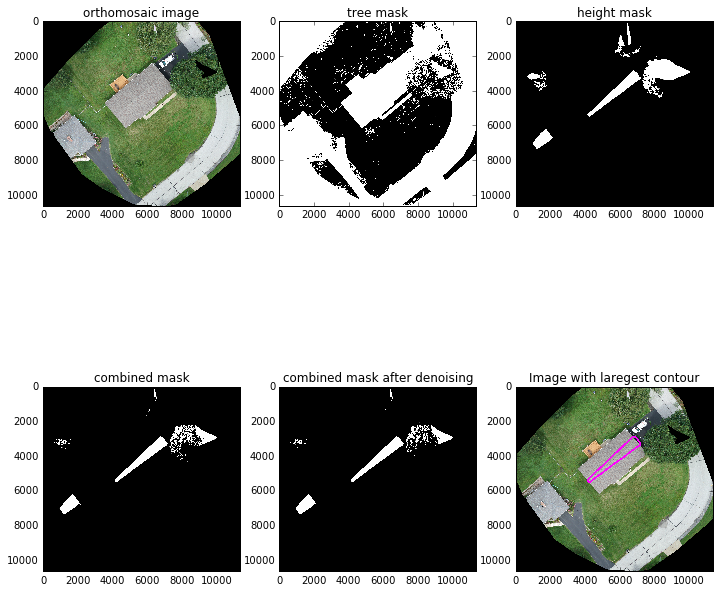

500.679010381


In [22]:
singletest('c6c0d1c9-7e16-40c4-9940-5dcbab822f6e')

Height Threshold : 3.500000 
The number of pixels in the largest contour is: 11879847.5
The index of contour which is the largst is: 21


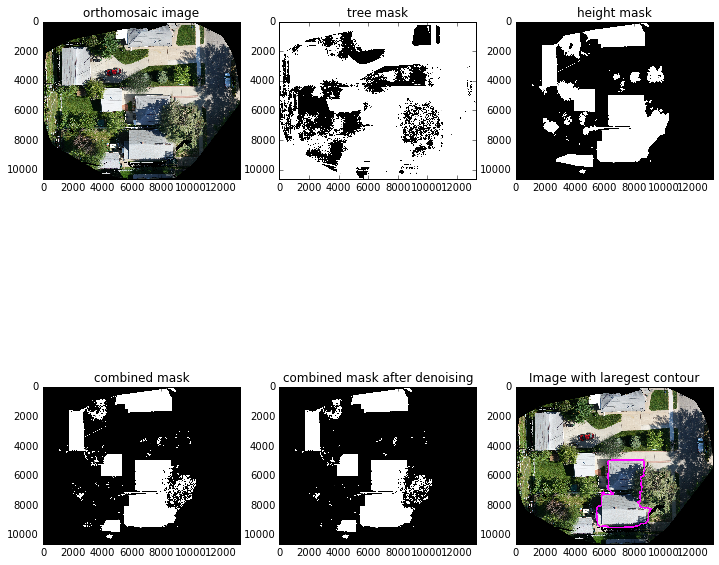

3326.64570922


In [23]:
singletest('773d2d69-e34c-4857-bfb2-225cc75b7b57')

In [181]:
def blob_selector(contours, selection_index, img_3d):
    cimg = np.zeros_like(img_3d)
    cv2.drawContours(cimg, contours, selection_index, color=255, thickness=-1)
    blob_of_interest = cimg * img_3d
    return blob_of_interest


def cutZeroPixels(Array3d):
    """
    This function reduces the array size to cut out as many zero pixels as
    possible while maintaining an mxn array shape. This is meant to reduce the
    computational time to run the median filter on the gradient array
    """
    
    cut_zero_rows = Array3d[~np.all(Array3d == 0, axis=1)]
    return cut_zero_rows[:, ~np.all(cut_zero_rows == 0, axis=0)]

def computeAreaByGradient(Array3D,area_one_pixel, window_size=9):
    # make sure to pass an array that has already been preped...
    #Array3D = metersToFeet(Array3D)
    g = np.gradient(Array3D)
    slope_multiplier = np.sqrt(g[0]**2 + g[1]**2 + 1) * (Array3D > 0)
    #slope_multiplier_blur = median_filter(slope_multiplier, window_size)
    #slope_multiplier_blur  = cv2.medianBlur(slope_multiplier, 149)
    slope_multiplier_blur = slope_multiplier
    pixel_area = slope_multiplier_blur * area_one_pixel* 10.7639
    return np.nansum(pixel_area), slope_multiplier_blur

def computeAreaByMedianGradient(Array3D, area_one_pixel):
    #Array3D = metersToFeet(Array3D)
    g = np.gradient(Array3D)
    slope_multiplier = np.sqrt(g[0]**2 + g[1]**2 + 1) * (Array3D > 0)
    slope_multiplier_median = np.median(slope_multiplier[slope_multiplier > 0])
    pixel_area = slope_multiplier_median * (Array3D > 0) * area_one_pixel * 10.7639
    return np.nansum(pixel_area) 

def compute_area_3d(contours, index, project_dsm):
    blob_of_interest = blob_selector(contours, index, project_dsm)
    cut = cutZeroPixels(blob_of_interest)
    area_one_pixel = pixW * pixH
    fast_est3d = computeAreaByMedianGradient(cut, area_one_pixel)
    est3d = computeAreaByGradient(cut,area_one_pixel, window_size=9)
    return fast_est3d,est3d

fast_est3d,est3d = compute_area_3d(contours, index, project_dsm)

In [185]:
print fast_est3d

2215.08


In [188]:
blob_of_interest = blob_selector(contours, index, project_dsm)
cut = cutZeroPixels(blob_of_interest)
area_one_pixel = pixW * pixH
Array3D = cut
g = np.gradient(Array3D)
slope_multiplier = np.sqrt(g[0]**2 + g[1]**2 + 1) * (Array3D > 0)
slope_multiplier_median = np.median(slope_multiplier[slope_multiplier > 0])
print slope_multiplier,slope_multiplier_median

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] 1.13273


In [195]:
np.sort(slope_multiplier)[:1]

array([[   0.        ,    0.        ,    0.        , ...,    1.48706162,
         579.93292236,  581.44696045]], dtype=float32)

### Tested Jing's largst contour plotting, works!

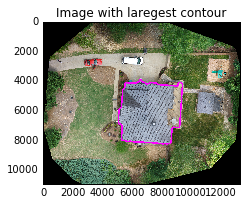

In [80]:
largest_contour = contours[index]
ImgWithContour = cv2.drawContours(rgbArray.copy(), [largest_contour], 0, (255,0,255), 100)
plt.figure(figsize=(12,12));
plt.subplot(231), plt.imshow(ImgWithContour), plt.title('Image with laregest contour')
plt.show()

### Verify and play around with exported contour

In [72]:
pixW,pixH,xOrigin,yOrigin = georef(filename) 
contour = contours[index]
xyz_tuple = [[contour[i].flatten().tolist()[0]*pixW + xOrigin,contour[i].flatten().tolist()[1]\
              *(-pixH)+yOrigin,project_dsm[contour[i].flatten().tolist()[0],contour[i].flatten().tolist()[1]]] \
             for i in range(len(contour))]


In [74]:
print [project_dsm[contour[i].flatten().tolist()[0],contour[i].flatten().tolist()[1]] for i in range(len(contour))]

[-0.63657624, -0.63495636, -0.62786573, -0.6240586, -0.61193144, -0.6075899, -0.60146141, -0.60059392, -0.60020816, -0.59977937, -0.5995419, -0.59945381, -0.59946793, -0.59945142, -0.59947652, -0.59943372, -0.59953713, -0.59946507, -0.59954005, -0.59946507, -0.59986085, -0.59973836, -0.6000073, -0.5998615, -0.60018361, -0.60003245, -0.60051501, -0.60028839, -0.60097712, -0.60084224, -0.60155541, -0.60147297, -0.60164863, -0.60138232, -0.60140121, -0.60012007, -0.60008222, -0.59916437, -0.59904009, -0.59768784, -0.59747237, -0.59622961, -0.59592885, -0.59429908, -0.59330356, -0.58486366, -0.58217633, -0.57373583, -0.57254076, -0.5654828, -0.56479847, -0.55914128, -0.5585779, -0.54667795, -0.54673707, -0.49069053, -0.48803636, -0.43982562, -0.43968353, -0.44910815, -0.44910815, -0.4207432, -0.41938952, -0.31603709, -0.31464979, -0.29371816, -0.29199383, -0.2725195, -0.27228883, -0.23983724, -0.23867749, -0.2236391, -0.22218855, -0.21477541, -0.21357648, -0.20502512, -0.20330894, -0.19083

In [75]:
contour_z = np.array([project_dsm[contour[i].flatten().tolist()[0],contour[i].flatten().tolist()[1]] for i in range(len(contour))])
contour_pos = np.array([contour[i].flatten().tolist() for i in range(len(contour))])

In [76]:
len(contour_z)

6660

In [77]:
len(contour_pos)

6660

In [78]:
new_contour_pos = contour_pos[contour_z > 0]

In [80]:
cv2.contourArea(cv2.convexHull(new_contour_pos))*0.00406*0.00406*1.302*10.7639

1818.540613800538

In [ ]:
def compute_area_2d(contours,index,pixW = 0.00406,pixH = 0.00406,s2rRatio = 1.302):

    """

    Compute area using 2d info

    """ 
    ##DICTIONARY COMPREHENSION EFFICIENT
    
    #c,index = max([(cv2.contourArea(v),i) for i,v in enumerate(contours)])
    
    
    sqM2sqF = 10.7639
    #area = cv2.contourArea(cv2.convexHull(contours[index]))*pixW*pixH*s2rRatio*sqM2sqF
    area = cv2.contourArea(contours[index])*pixW*pixH*s2rRatio*sqM2sqF
    return area

## Color mask using orthomosaic

In [85]:
mosaicfile = '/Users/ejlq/Documents/ARI-Hackweek/training/989f9066-5eec-4d2e-b684-c631a9937243/orthomosaic_rgb/project_transparent_mosaic_rgb.tif'
mosaic_img = cv2.imread(mosaicfile)
resized = resize(mosaic_img)
# lower_red = np.array([15,114,209]) # manually set lower BGR limit -- TODO:find a way to auto set
# upper_red = np.array([200,200,253]) # manually set upper BGR limit
# mask = cv2.inRange(img,lower_red,upper_red) # create a mask using the color limits
# masked = cv2.bitwise_and(img,img,mask=mask) # apply the mask to image, this will leave the pixels not falling
#                                                 # into the limits all to black
# return masked

### An alternative way?

In [13]:
def get_area_single(args):
    child_dir, directory, cutoff = args
    
    try:
         # read the dsm file
        img = readImg(directory + child_dir + '/dsm/project_dsm.tif')
        
        # remove outliers
        img = removeOutliers(img, outlier_cut=2.5)
        
        # scale the pixel values to lie between 0 and 1
        img = standardScaler(img)
        
        # get blobs
        img_bool = getBlobsFromTif2(img, cutoff)
        
        # perform median filtering
        img_bool_median_filter = cv2.medianBlur(img_bool, 149)

#         # get contours
#         contours = getContours(img_bool_median_filter)
        
#         # get max area of contours
#         max_area = getMaxArea(contours)
            
    except ValueError, AttributeError:
        max_area = np.nan
        
    return (contours)

In [44]:
def readImg(path_to_tif):
    """
    Use project_dsm.tif file!
    """
    
    pixelDS = gdal.Open(path_to_tif)
    dsm_data = pixelDS.GetRasterBand(1)
    return dsm_data.ReadAsArray()

def standardScaler(img):

    img[img < -500] = np.nan
    img -= np.nanmin(img)
    img[img > 10] = np.nan
    img /= np.nanmax(img)
    img[np.isnan(img)] = -10000
    return img

def removeOutliers(img, outlier_cut=2.5):
    temp = np.ravel(img)
    temp = temp[temp != -int(1e4)]
    img[img > temp.mean() + outlier_cut * temp.std()] = temp.min()
    return img

def getBlobsFromTif2(img, cutoff = 0.5):
    
    return np.array(img > cutoff, dtype=np.uint8)


